# Midterm 1 Assignment 6 Davide Amadei

#### Various Imports and utilities

In [18]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [19]:
def show_img(image: np.ndarray, gray: bool = True, title: str = None) -> None:
    """simple utility to show images with axes disabled

    Parameters
    ----------
    image : np.ndarray
        image to show
    gray : bool, optional
        if true show image in grayscale, by default True
    """
    if gray:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

## Implementation of necessary methods

### Convolution Method

Padding for boundaries of image is handled by replicating the nearest element of the image by default. This can be changed to any type of padding supported by OpenCV

In [20]:
def img_filter_convolution(image: np.ndarray, filter: np.ndarray, padtype=cv2.BORDER_REPLICATE) -> np.ndarray:
    """function to convolve an image with a filter

    Parameters
    ----------
    image : np.ndarray
        image to convolve
    filter : np.ndarray
        filter to convolve
    padtype : _type_, optional
        type of padding to use, by default cv2.BORDER_REPLICATE

    Returns
    -------
    np.ndarray
        result of convolution of image with filter
    """
    x_size, y_size = image.shape
    filter_size = filter.shape[0]
    padding = filter_size//2
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, padtype)
    filtered_img = np.zeros((x_size, y_size))

    for x in range(x_size):
        for y in range(y_size):
            filtered_img[x, y] = (padded_image[x: x+filter_size, y:y+filter_size] * filter).sum()
    return filtered_img

### Gaussian Filter Implementation
The filter is created using a radius $r$ of $\lceil 3 \sigma \rceil$. This gives a filter of size $(2r + 1)\times(2r + 1)$. This size is always odd, allowing convolution of the filter with an image as it can be centered on each of its pixels.<br>
This size was picked because the values of the filter become very small after that point, thus making it a good cutoff for a discrete approximation of a Gaussian filter.<br>
Implementation of this filter was not required but it was useful for testing purposes and to later implement the LoG filter.

In [21]:
def gaussian_filter(scale: float, size: int = None) -> np.ndarray:
    """function returning a gaussian filter at given scale

    Parameters
    ----------
    scale : float
        scale to use for the gaussian filter
    size : int, optional
        size of filter, by default None

    Returns
    -------
    np.ndarray
        the gaussian filter at given scale and either given size or computed one
    """
    #if size of the filter is not given, use ceiling of 3*scale as radius r, giving a filter of size (2*r + 1)x(2*r +1)
    if size is None:
        size = int(2 * np.ceil(3*scale)) + 1
    v = np.arange((-size // 2) + 1, (size // 2) + 1)
    x = v * np.ones((size, size))
    y = x.T
    filter = 1/(2*np.pi*scale**2) * np.exp(-(x*x + y*y)/(2*scale**2))
    return filter

### LoG Filter Implementation

To determine the size of the filter the same method as the Gaussian filter was used.

In [22]:
def LoG(scale: float, size:int = None) -> np.ndarray:
    """function returning a laplacian of gaussian filter at given scale

    Parameters
    ----------
    scale : float
        scale to use for the gaussian filter
    size : int, optional
        size of filter, by default None

    Returns
    -------
    np.ndarray
        the LoG filter at given scale and either given size or computed one
    """
    if size is None:
        size = int(2 * np.ceil(3*scale)) + 1
    v = np.arange((-size // 2) + 1, (size // 2) + 1)
    x = v * np.ones((size, size))
    y = x.T
    gaussian = 1/(2*np.pi*scale**2) * np.exp(-(x*x + y*y)/(2*scale**2))
    log_filter = scale * scale * ((x*x + y*y)/(scale**4) - 2/(scale**2))*gaussian
    return log_filter


### Blob Detection Implementation

The detector works by first centering on each point of the image (thus requiring padding on boundaries). At each point it takes a $3 \times 3$ slice of the image centered on that point, and it checks if the maximum response in that slice, across all considered scales, is over the threshold. <br>
If it is, it checks if the maximum that was found is centered in the image slice, in which case it is added to the list of points that are considered centers of blobs. 

In [23]:
def blob_detector(image: np.ndarray, base_scale:float = 1, k = 6, threshold:float = 0.03) -> list[tuple[int, int, float]]:
    """function implementing a scale space blob detector

    Parameters
    ----------
    image : np.ndarray
        image to run blob detection on
    base_scale : float
        base scale to use for blob detection
    k : int
        number of scales to use
    threshold : float, optional
        a point that is a potential center of a blob must be greater than this value to be actually picked, by default 0.03

    Returns
    -------
    list[tuple[int, int, float]]
        a list containing tuples where the first two elements are coordinates and the third is the scale at which that point was chosen.
        Each tuple is the center of a blob at that scale
    """
    outputs = []
    
    # multiply base scale by increasing powers of 2 to obtain a list of scales
    scales = [base_scale*(2**i) for i in range(k)]
    img_x, img_y = image.shape
    for scale in scales:
        filter = LoG(scale)
        output = img_filter_convolution(image, filter)
        # take square of response to find both dark and bright blobs
        output = output * output
        # padding for boundaries handling
        output = cv2.copyMakeBorder(output, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
        outputs.append(output)
    outputs = np.asarray(outputs)
    
    centers = []
    for x in range(1, img_x+1):
        for y in range(1, img_y+1):
            # take 3x3 slice on all scales
            current_slice = outputs[:,x-1:x+2,y-1:y+2]

            # check if max is over threshold
            if np.amax(current_slice) > threshold:
                # find index of max
                indices = np.unravel_index(np.argmax(current_slice), current_slice.shape)

                # check if max is in center of slice
                if indices[1] == 1 and indices[2] == 1:
                    centers.append((x, y, scales[indices[0]]))
    return centers


Simple function to plot circles that represent blobs. The radius of each circle is $\sqrt{2} \sigma$ where $\sigma$ is the scale of that blob. This radius was used because it gives the circle where a LoG of scale $\sigma$ has maximum response.

In [24]:
def plot_blobs(image: np.ndarray, centers: list[tuple[int,int,float]], title: str = "Plot of blobs") -> None:
    """function to plot circles representing blobs based on the given list of center points

    Parameters
    ----------
    image : np.ndarray
        image to plot blobs on
    centers : list[tuple[int,int,float]]
        list of tuples of shape (x, y, scale) giving coordinates of a blob and its scale
    title : str, optional
        title of image to displat, by default "Plot of blobs"
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    for x, y, scale in centers:
        c = plt.Circle((y, x), scale*np.sqrt(2), color="red", linewidth = 1.5, fill=False)
        ax.add_patch(c)
    ax.plot()
    plt.axis("off")
    plt.title(title)
    plt.show()

## Tests for LoG filter and convolution

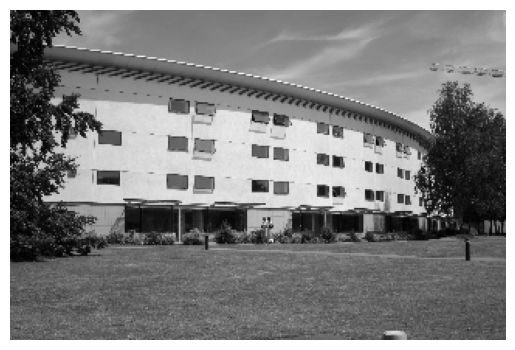

In [25]:
image = cv2.imread("./MSRC_ObjCategImageDatabase_v1/3_22_s.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image normalizion and moving to grayspace instead of RGB
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
show_img(gray)

Test for the image convolution method using a gaussian filter

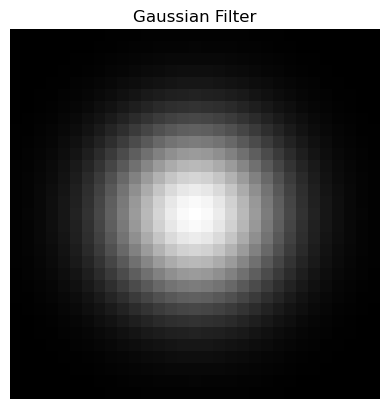

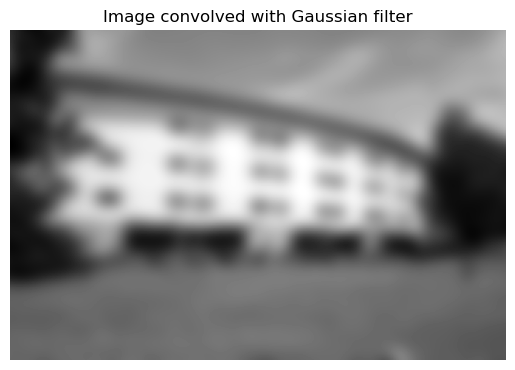

In [26]:
gauss = gaussian_filter(5)
blurred_img = img_filter_convolution(gray, gauss)

show_img(gauss, title="Gaussian Filter")
show_img(blurred_img, title="Image convolved with Gaussian filter")

Test for the Laplacian of Gaussian filter

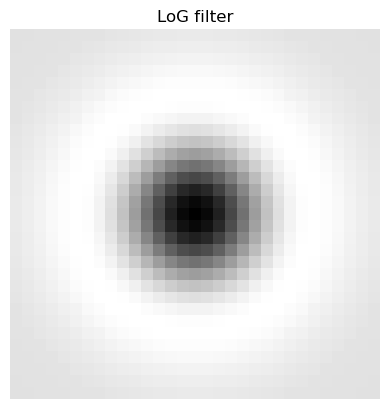

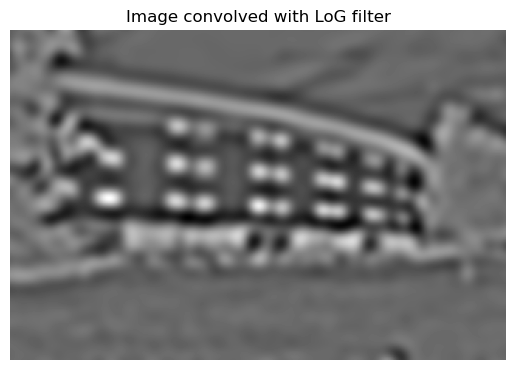

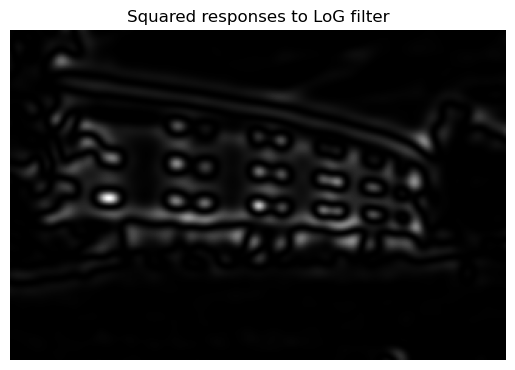

In [27]:
laplacian = LoG(5)
laplacian_img = img_filter_convolution(gray, laplacian)

show_img(laplacian, title="LoG filter")
show_img(laplacian_img, title="Image convolved with LoG filter")
show_img(laplacian_img*laplacian_img, title="Squared responses to LoG filter")

## Blob detection on selected images

The images were chosen as using the algorithm on them allows a good showcase of what the algorithm can do and its limitations. <br>
We will use the same scales and the same threshold for all images but for better results it would be best to use different values for each image

In [28]:
# threshold was picked by hand by checking results and seeing the blobs that are found and the range of values
# obtained at each point by the blob detector
threshold = 0.03

base_scale = 2

k = 6

### Image 1

In this image we can see one of the faults of the LoG blob detector. The wheel on the left is facing the camera, making it appear circular and thus the blob detector is able to pick it up. The one on the right, on the other hand, is slightly slanted, making it more of an ellipsoid, rendering the blob detector unable to detect it, as it only works with circular blobs.<br>
The rest of the image has alright results, with the car windows being detected and the part of the car being split in various blobs. The smaller scales detect blobs in some random spots and there are some large blobs on the ground despite no apparent reason.

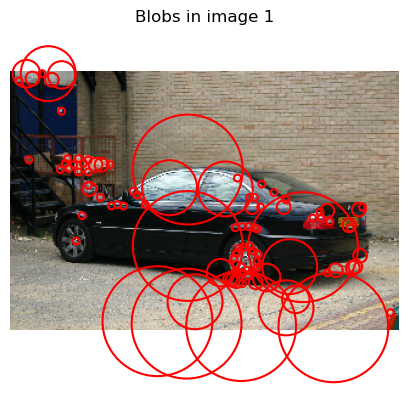

In [29]:
image = cv2.imread("./images/image1.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in image 1")


### Image 2

In this image the blob detector works surprisingly well, and despite splitting the face in multiple blobs of varying sizes there are not many stray blobs, as it should be, given the rest of the image is generally uniform in color. Weirdly enough, only one eye is detected even though both are front facing.<br>
The largest scale space is even somewhat able to detect the whole face.

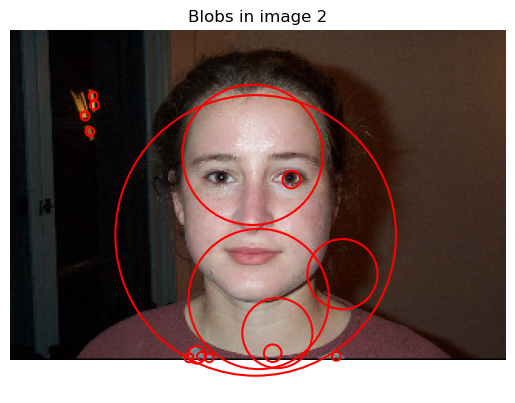

In [30]:
image = cv2.imread("./images/image2.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in image 2")


### Image 3

The most "correct" thing that is detected in this image are the windows of the building. The larger scale spaces are also splitting the building in multiple blobs, to a degree, but it is not particularly precise.<br>
Interestingly, the holes left by the leaves of the trees are picked up as blobs, as they are after all a brighter circle on a dark background, leading to a high response when a LoG filter is applied.

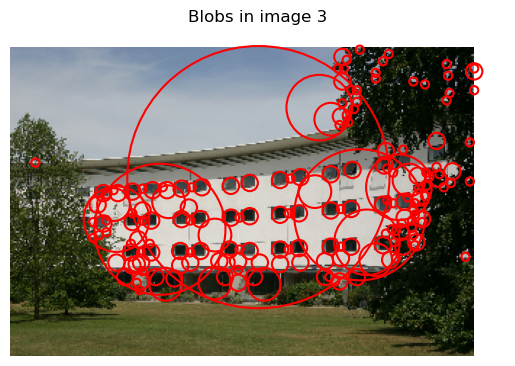

In [31]:
image = cv2.imread("./images/image3.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in image 3")

### Image 4

In this image the cows are correctly (given the limitations of the algorithm) detected as compositions of blobs. The roof in the background is also detected as multiple blobs probably because of how bright it is.

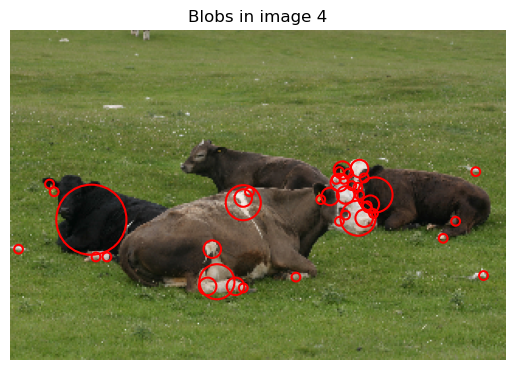

In [32]:
image = cv2.imread("./images/image4.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in image 4")

### Image 5

With the cows closer together the algorithm works a lot worse as the boundaries between each other are much less clear, leading to the algorithm only detecting the white spots on their body.

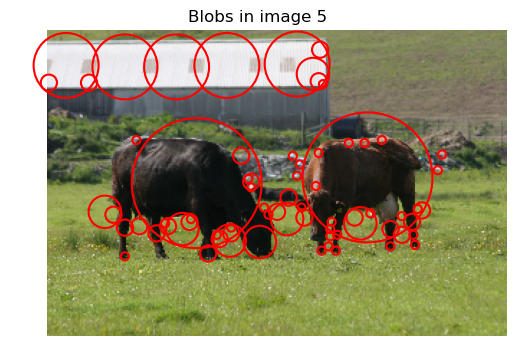

In [33]:
image = cv2.imread("./images/image5.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in image 5")


### Extra Image
Image outside of the given dataset to show an example where blob detector works decently and picks up everything you would expect, both dark blobs (e.g. the center of the sunflowers) and bright blobs (e.g. the sun).

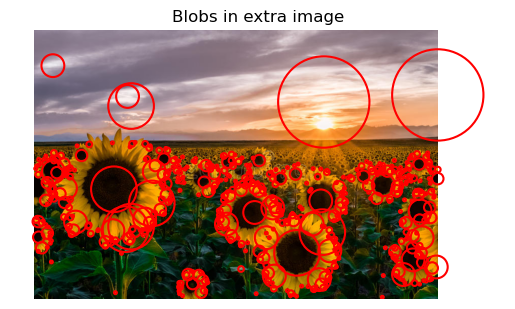

In [34]:
image = cv2.imread("./images/extra.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# normalize image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

results = blob_detector(gray, base_scale=base_scale, k=k, threshold=threshold)
plot_blobs(image, results, "Blobs in extra image")

## Final remarks

I picked this assignment as in general implementing stuff from scratch allows me to better understand how a topic works. This held true in this case as well. In particular I was unsure of how to actually select the blobs after running the convolution, and it is a lot clearer now.<br>
On this subject, while it works as it is currently, there is probably a large margin of improvement on that front, as in each window it only checks for a single maximum value across all scale. It might be useful to do a finer search to keep potentially good points.<br><br>

The code is also quite slow, using DoG instead of LoG would likely be a nice speedup and if done smartly could also lead to better efficiency in terms of space.<br><br>

In general the analysis could be improved by trying more scales and varying thresholds, but the results obtained on the images are already acceptable, as in each image it detects what one could generally think of as a circular blob. Of course using LoG for blob detection has limits and they can be seen even in these small examples. <br>
The biggest issues can be seen in images 1 and 5, as described in their respective sections, but all images aside from image 2 have a lot of "noise", with a lot of blobs in seemingly random locations. These blobs are more frequent at small scale spaces, which is not too surprising.<br>
Another variable that could maybe change results in some cases is also how padding is handled at image boundaries, and it could be useful to try the different ways to check if one leads to better results.